In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# pre processing
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df = df.copy()
df["month"] = df["month"].astype("category")
df["contact"] = df["contact"].astype("category")
df["day_of_week"] = df["day_of_week"].astype("category")
df = df[df["poutcome"] != "nonexistent"]
df['poutcome'] = df['poutcome'].map({'success': 1, 'failure': 0})
X = df[["month", "day_of_week", "contact", "poutcome"]]

In [15]:

class Campaign:
    def __init__(self, day_of_week="mon", month="jan", contact="telephone"):
        """Initialize campaign with default values."""
        self.day_of_week = day_of_week
        self.month = month
        self.contact = contact

    def optimize_campaign(self, df):
        ## Select the best  day, contact method, and month 
        success_by_day = df.groupby("day_of_week",  observed=False)["poutcome"].mean().sort_values(ascending=False)
        success_by_contact = df.groupby("contact",  observed=False)["poutcome"].mean().sort_values(ascending=False)
        success_by_month = df.groupby("month", observed=False)["poutcome"].mean().sort_values(ascending=False)

        # Update 
        self.day_of_week = success_by_day.idxmax()
        self.contact = success_by_contact.idxmax()
        self.month = success_by_month.idxmax()

        print(f"Optimized Campaign: Day = {self.day_of_week}, Contact = {self.contact}, Month = {self.month}")


# Initialize Campaign
campaign = Campaign()

# Optimize Campaign Based on Past Data
campaign.optimize_campaign(df)

# Check Updated Campaign Parameters
print(f"New Best Campaign Strategy -> Day: {campaign.day_of_week}, Month: {campaign.month}, Contact: {campaign.contact}")


Optimized Campaign: Day = thu, Contact = telephone, Month = dec
New Best Campaign Strategy -> Day: thu, Month: dec, Contact: telephone


/var/folders/nf/fvzp8jgx7w5d98kpy9l2zh2r0000gn/T/ipykernel_27512/3541790544.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[["housing", "default", "loan"]] = df[["housing", "default", "loan"]].replace({"yes": 1, "no": 0})


<bound method NDFrame.head of        age  default  housing  loan  duration  campaign  pdays  previous  \
24013   38        0        1     0        39         1    999         1   
24019   40        0        1     0       144         1    999         1   
24076   36        0        1     0       449         1    999         1   
24102   36        0        1     0       114         1    999         1   
24108   37        0        1     0       119         1      6         1   
...    ...      ...      ...   ...       ...       ...    ...       ...   
41174   62        0        1     0       208         1      1         6   
41175   34        0        1     0       180         1    999         2   
41178   62        0        0     0       483         2      6         3   
41182   29        0        1     0       112         1      9         1   
41187   74        0        1     0       239         3    999         1   

       poutcome  emp.var.rate  ...  education_basic.6y  education_bas

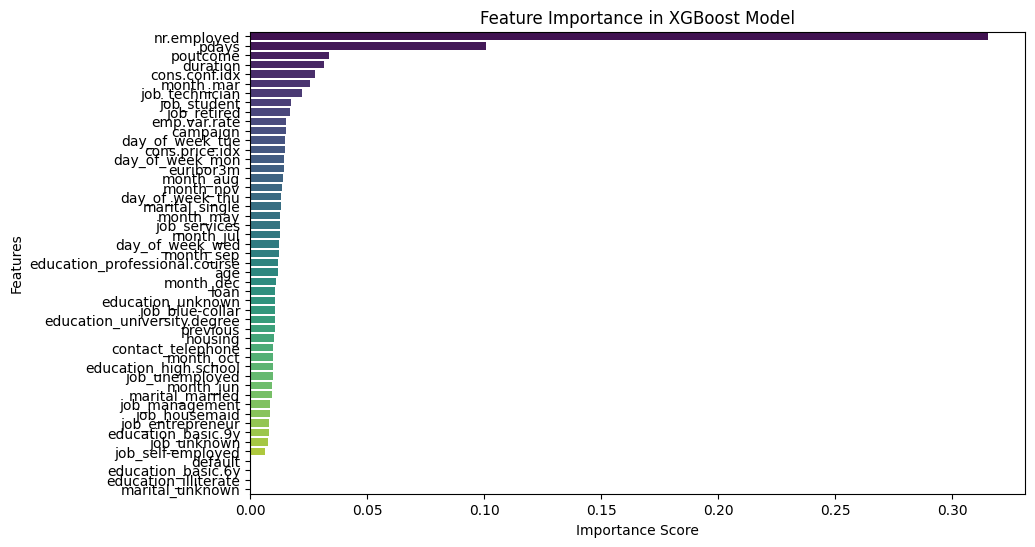

In [31]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Check dataset structure
df = pd.read_csv('../data/raw_data/bank_marketing_dataset.csv')
df = df.copy()
df = df[(df["poutcome"] != "nonexistent") & 
        (df["housing"] != "unknown") & 
        (df["default"] != "unknown") & 
        (df["loan"] != "unknown")]
df[["housing", "default", "loan"]] = df[["housing", "default", "loan"]].replace({"yes": 1, "no": 0})
df['poutcome'] = df['poutcome'].map({'success': 1, 'failure': 0})

# Encode categorical variables using One-Hot Encoding
categorical_features = ["contact", "day_of_week", "month", "job", "education", "marital"]
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Define features (X) and target (y)
X = df.drop(columns=["subscribed"])  # Drop target variable
df['subscribed'] = df['subscribed'].map({'yes': 1, 'no': 0})
y = df["subscribed"]  # Target variable (0 or 1)

print(X.head)
print(y.head)

# Split into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(eval_metric="logloss", random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance Analysis
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis", hue="Feature", legend=False)
plt.title("Feature Importance in XGBoost Model")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()